In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_csv('../data/carclaims.csv')

# Drop irrelevant columns
df = df.drop(['PolicyNumber', 'RepNumber', 'Year'], axis=1)

# Prepare features and target
X = df.drop('FraudFound', axis=1)
y = df['FraudFound'].map({'No': 0, 'Yes': 1})

# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# One-hot encode categorical variables
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

In [3]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)

print(f"After SMOTE - Class distribution: {np.bincount(y_train_balanced)}")

After SMOTE - Class distribution: [11598 11598]


In [4]:
# hyper parameter grid
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

In [5]:
# configure randomized search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

In [6]:
# run hyperparameter tuning
random_search.fit(X_train_balanced, y_train_balanced)

print("Best Parameters:", random_search.best_params_)
print(f"Best CV AUC: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}
Best CV AUC: 0.9910


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.69      0.06      0.11       185

    accuracy                           0.94      3084
   macro avg       0.82      0.53      0.54      3084
weighted avg       0.93      0.94      0.92      3084



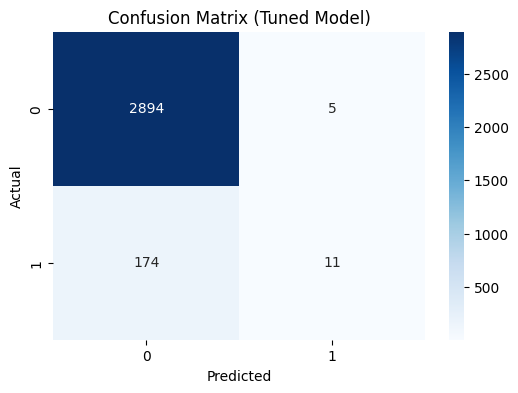

Test AUC-ROC Score (Tuned Model): 0.8267


In [7]:
# Evaluate best model on test set
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test_encoded)
y_proba = best_model.predict_proba(X_test_encoded)[:, 1]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Tuned Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

auc = roc_auc_score(y_test, y_proba)
print(f"Test AUC-ROC Score (Tuned Model): {auc:.4f}")

In [13]:
import joblib
import os

# Create the results directory if it doesn't exist
os.makedirs('../results', exist_ok=True)

# Save the best model
joblib.dump(best_model, '../results/best_smote_model.joblib')
print("Model saved successfully.")

# Save the preprocessing pipeline
joblib.dump(preprocessor, '../results/preprocessor.joblib')
print("Preprocessor saved successfully.")

# Save test data
np.save('../data/X_test_encoded.npy', X_test_encoded)
np.save('../data/y_test.npy', y_test)
print("Test data saved successfully.")

Model saved successfully.
Preprocessor saved successfully.
Test data saved successfully.


In [15]:
# Get the feature names from the preprocessor
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out()

# If you used ColumnTransformer with remainder='passthrough', combine with numerical features
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Combine categorical and numerical feature names
all_feature_names = np.concatenate([onehot_feature_names, numerical_cols])

print(f"Number of features: {len(all_feature_names)}")

with open('../results/feature_names.json', 'w') as f:
    json.dump(all_feature_names.tolist(), f)

Number of features: 145


In [9]:
import json

# Create the directory if it doesn't exist
os.makedirs("../results", exist_ok=True)

# Save the results
results = {
    "best_params": random_search.best_params_,
    "auc": auc
}

with open("../results/tuned_model_results.json", "w") as f:
    json.dump(results, f)

print("Results saved successfully.")

Results saved successfully.
